# Computational materials science

## Introduction
In this tutorial, you will use `AiiDA-WorkTree` to carry out a DFT calculation using Quantum ESPRESSO.

## Requirements
To run this tutorial, you need to install `aiida-worktree`, `aiida-quantumespresso` and `aiida-pseudo`. Open a terminal and run:

```console
pip install aiida-worktree aiida-quantumespresso aiida-pseudo
aiida-pseudo install sssp -x PBEsol
```

Start the AiiDA daemon if needed:
```console
verdi daemon start
```

Load the AiiDA profile.

In [1]:
%load_ext aiida
from aiida import load_profile
load_profile()

Profile<uuid='2fc245067596472e99d07ed3a64b1140' name='aiida'>

## First workflow: calculate the energy of N2 molecule

### Create a PW node
aiida-quantumespresso provides a CalcJob: `PwCalculation` to run a PW calculation. Let's register it as a node:

In [2]:
from aiida_worktree import build_node

# register node
ndata = {"path": "aiida_quantumespresso.calculations.pw.PwCalculation"}
pw_node = build_node(ndata)

The inputs and outputs of the `PwCalculation` is automatically generated for the new node. One can create a node instance and inpsect its inputs and outputs:

In [3]:
node = pw_node()
# only show first level inputs and outputs
print("Inputs:")
for input in node.inputs:
    if "." not in input.name:
        print(f"  - {input.name}")
print("Outputs:")
for output in node.outputs:
    if "." not in output.name:
        print(f"  - {output.name}")

Inputs:
  - metadata
  - code
  - monitors
  - remote_folder
  - structure
  - parameters
  - settings
  - parent_folder
  - vdw_table
  - pseudos
  - parallelization
  - kpoints
  - hubbard_file
Outputs:
  - remote_folder
  - remote_stash
  - retrieved
  - output_parameters
  - output_structure
  - output_trajectory
  - output_band
  - output_kpoints
  - output_atomic_occupations


### Prepare the input datas

In [4]:
from aiida_worktree import WorkTree
from aiida import load_profile
from aiida.orm import Dict, KpointsData, StructureData, load_code, load_group
from ase.build import molecule

load_profile()
# create input structure node
mol = molecule("N2")
mol.center(vacuum=1.5)
mol.pbc = True
structure_n2 = StructureData(ase=mol)
# create the PW node
code = load_code("pw-7.2@localhost")
paras = Dict({
        "CONTROL": {
            "calculation": "scf",
        },
        "SYSTEM": {
            "ecutwfc": 30,
            "ecutrho": 240,
            "occupations": "smearing",
            "smearing": "gaussian",
            "degauss": 0.1,
        },
    })
kpoints = KpointsData()
kpoints.set_kpoints_mesh([1, 1, 1])
# Load the pseudopotential family.
pseudo_family = load_group('SSSP/1.2/PBEsol/efficiency')
pseudos = pseudo_family.get_pseudos(structure=structure_n2)
#
metadata = {
    'options': {'resources': {
                'num_machines': 1,
                'num_mpiprocs_per_machine': 1,
            },
        }
    }


### Define a worktree

In [5]:
nt = WorkTree("energy_n2")
# structure node
structure1 = nt.nodes.new("AiiDANode", "n2", value=structure_n2)
# pw node
pw1 = nt.nodes.new(pw_node, name="pw1")
pw1.set({"code": code,
        "parameters": paras,
        "kpoints": kpoints,
        "pseudos": pseudos,
        "metadata": metadata
        })
nt.links.new(structure1.outputs[0], pw1.inputs["structure"])
nt.submit(wait=True, timeout=200)

[INFO] 2023-07-21 15:34:03 nodetree: Create NodeTree: energy_n2


### Check status and results
Get the result of the nodes:

In [6]:
print('Energy of an un-relaxed N2 molecule: {:0.3f}'.format(pw1.node.outputs.output_parameters.get_dict()["energy"]))

Energy of an un-relaxed N2 molecule: -547.169


Generate node graph from the AiiDA process:

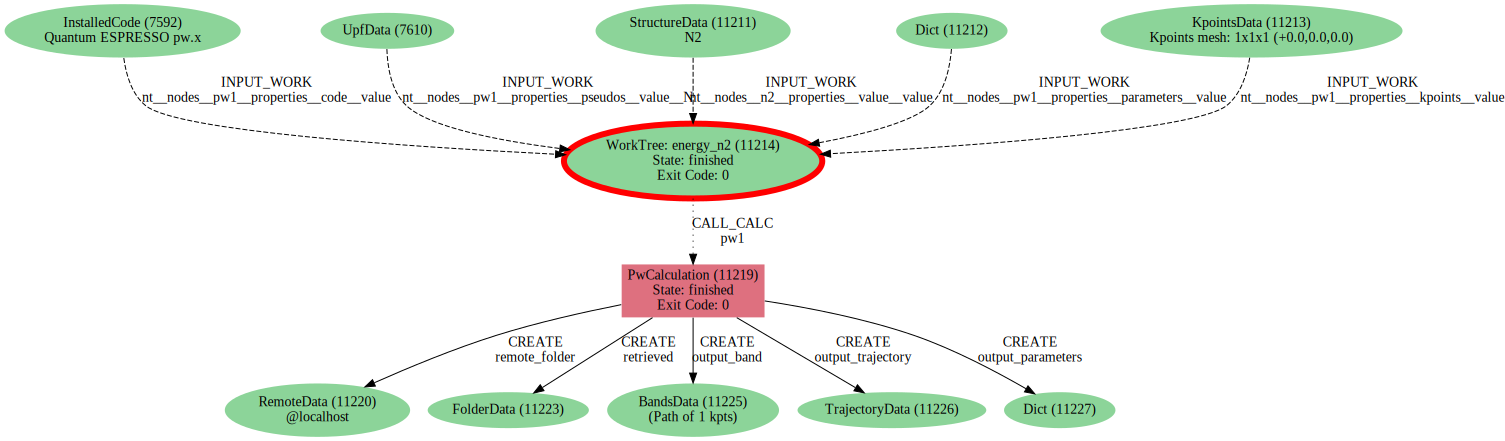

In [7]:
from aiida_worktree.utils import generate_node_graph
generate_node_graph(nt.pk)

## Second workflow: atomization energy of N2 molecule

The atomization energy of $N_2$ is defined as the energy difference between the $N_2$ molecule and two isolated N atoms.
```python
e_atomization = 2 * e_atom - e_molecule
````

### Define a calcfunction to calculate the atomization energy

In [8]:
from aiida_worktree import node
from aiida.engine import calcfunction


@node(outputs = [["General", "energy"]])
@calcfunction
def atomization_energy(output_atom, output_mol):
    from aiida.orm import Float
    e = output_atom["energy"]*output_mol["number_of_atoms"] - output_mol["energy"]
    return Float(e)

Create the structure of nitrogen Atom.

In [9]:
from ase import Atoms
from aiida.orm import StructureData

atoms = Atoms("N")
atoms.center(vacuum=1.5)
atoms.pbc = True
structure_n = StructureData(ase=atoms)

### Create a worktree

In [10]:
from aiida_worktree import WorkTree
from aiida.orm import Dict, KpointsData, StructureData, load_code, load_group

nt = WorkTree("atomization_energy")

nt.nodes.new("AiiDANode", "n2", value=structure_n2)
nt.nodes.new("AiiDANode", "n", value=structure_n)
# create the PW node
pw_n = nt.nodes.new(pw_node, name="pw_n")
pw_n.set({"code": code, "parameters": paras, "kpoints": kpoints,
          "pseudos": pseudos, "metadata": metadata
        })
pw_n2 = nt.nodes.new(pw_node, name="pw_n2")
pw_n2.set({"code": code, "parameters": paras, "kpoints": kpoints,
          "pseudos": pseudos, "metadata": metadata
        })
# create the node to calculate the atomization energy
atomization = nt.nodes.new(atomization_energy, name="atomization_energy")
nt.links.new(nt.nodes["n"].outputs[0], pw_n.inputs["structure"])
nt.links.new(nt.nodes["n2"].outputs[0], pw_n2.inputs["structure"])
nt.links.new(pw_n.outputs["output_parameters"], atomization.inputs["output_atom"])
nt.links.new(pw_n2.outputs["output_parameters"], atomization.inputs["output_mol"])
nt.submit(wait=True, timeout=300)


[INFO] 2023-07-21 15:35:04 nodetree: Create NodeTree: atomization_energy


In [11]:
nt.update()
print('Atomization energy: {:0.3f} eV'.format(atomization.node.outputs.result.value))


Atomization energy: 14.451 eV


Generate node graph from the AiiDA process:

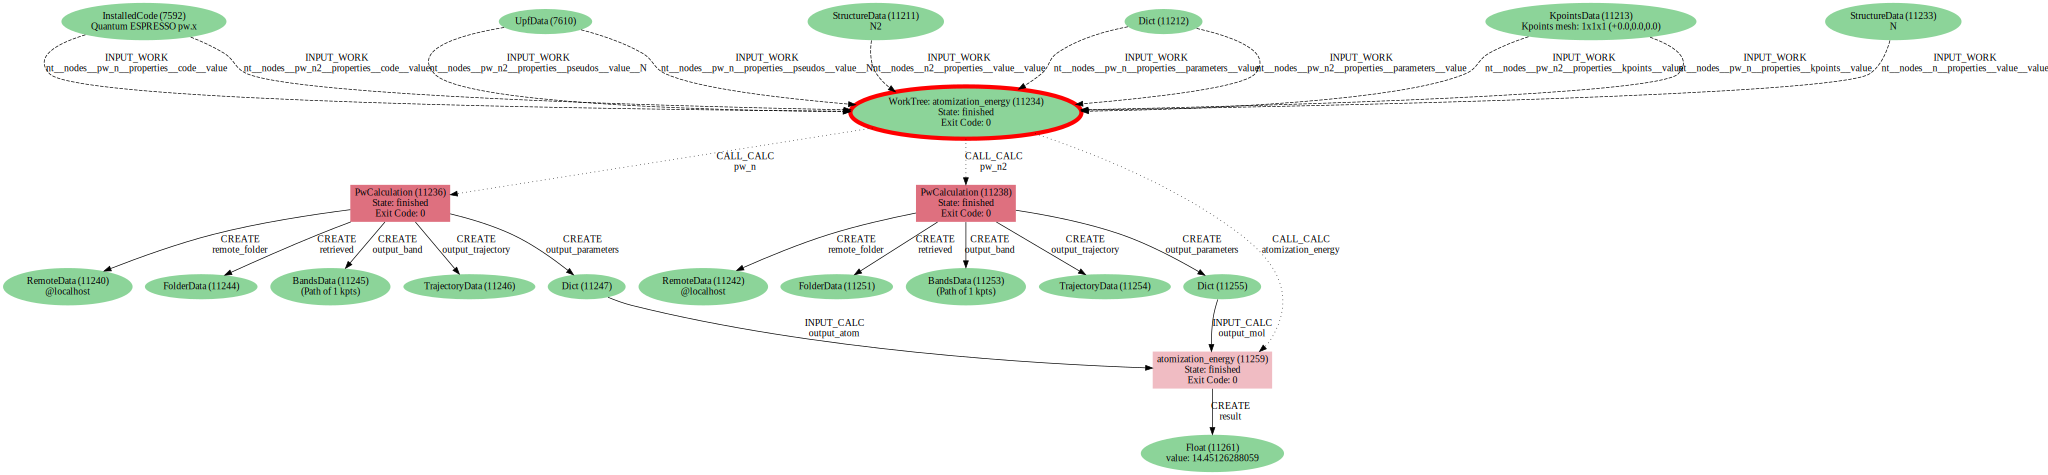

In [12]:
from aiida_worktree.utils import generate_node_graph
generate_node_graph(nt.pk)

## Use already existing workchain
Can we register a node from a workchain? Can we set the a input item of a namespace? Yes, we can!

Here we build a node from the `PwRelaxWorkChain`.

In [13]:
from aiida_worktree.decorator import build_node

# register node
ndata = {"path": "aiida_quantumespresso.workflows.pw.relax.PwRelaxWorkChain"}
pw_relax_node = build_node(ndata)

In the `PwRelaxWorkChain`, one can set the relax type (`calculation` key) in the input namespace `base.pw.parameters`. Now we create a new node to update the pw parameters.

In [14]:
from aiida_worktree.decorator import node
from aiida.engine import calcfunction


@node()
@calcfunction
def pw_parameters(paras, relax_type):
    paras1 = paras.clone()
    paras1["CONTROL"]["calculation"] = relax_type
    return paras1

Now, we create the worktree to relax the structure of N2 molecule.

In [15]:
nt = WorkTree("test_pw_relax")
# structure node
nt.nodes.new("AiiDANode", "n2", value=structure_n2)
# pw node
pw_relax1 = nt.nodes.new(pw_relax_node, name="pw_relax1")
pw_relax1.set({
        "base": {
                "pw": {
                        "code": code,
                        "pseudos": pseudos,
                        "metadata": metadata
                },
                "kpoints": kpoints,
                },
        
        })
paras_node = nt.nodes.new(pw_parameters, "parameters",
                          paras = paras,
                          relax_type = "relax")
nt.links.new(nt.nodes["n2"].outputs[0], pw_relax1.inputs["structure"])
nt.links.new(paras_node.outputs[0], pw_relax1.inputs["base.pw.parameters"])
nt.submit(wait=True, timeout=200)

[INFO] 2023-07-21 15:36:32 nodetree: Create NodeTree: test_add_multiply


In [16]:
nt.update()
print('Energy of a relaxed N2 molecule: {:0.3f}'.format(pw_relax1.node.outputs.output_parameters.get_dict()["energy"]))

Energy of a relaxed N2 molecule: -547.232


Generate node graph from the AiiDA process:

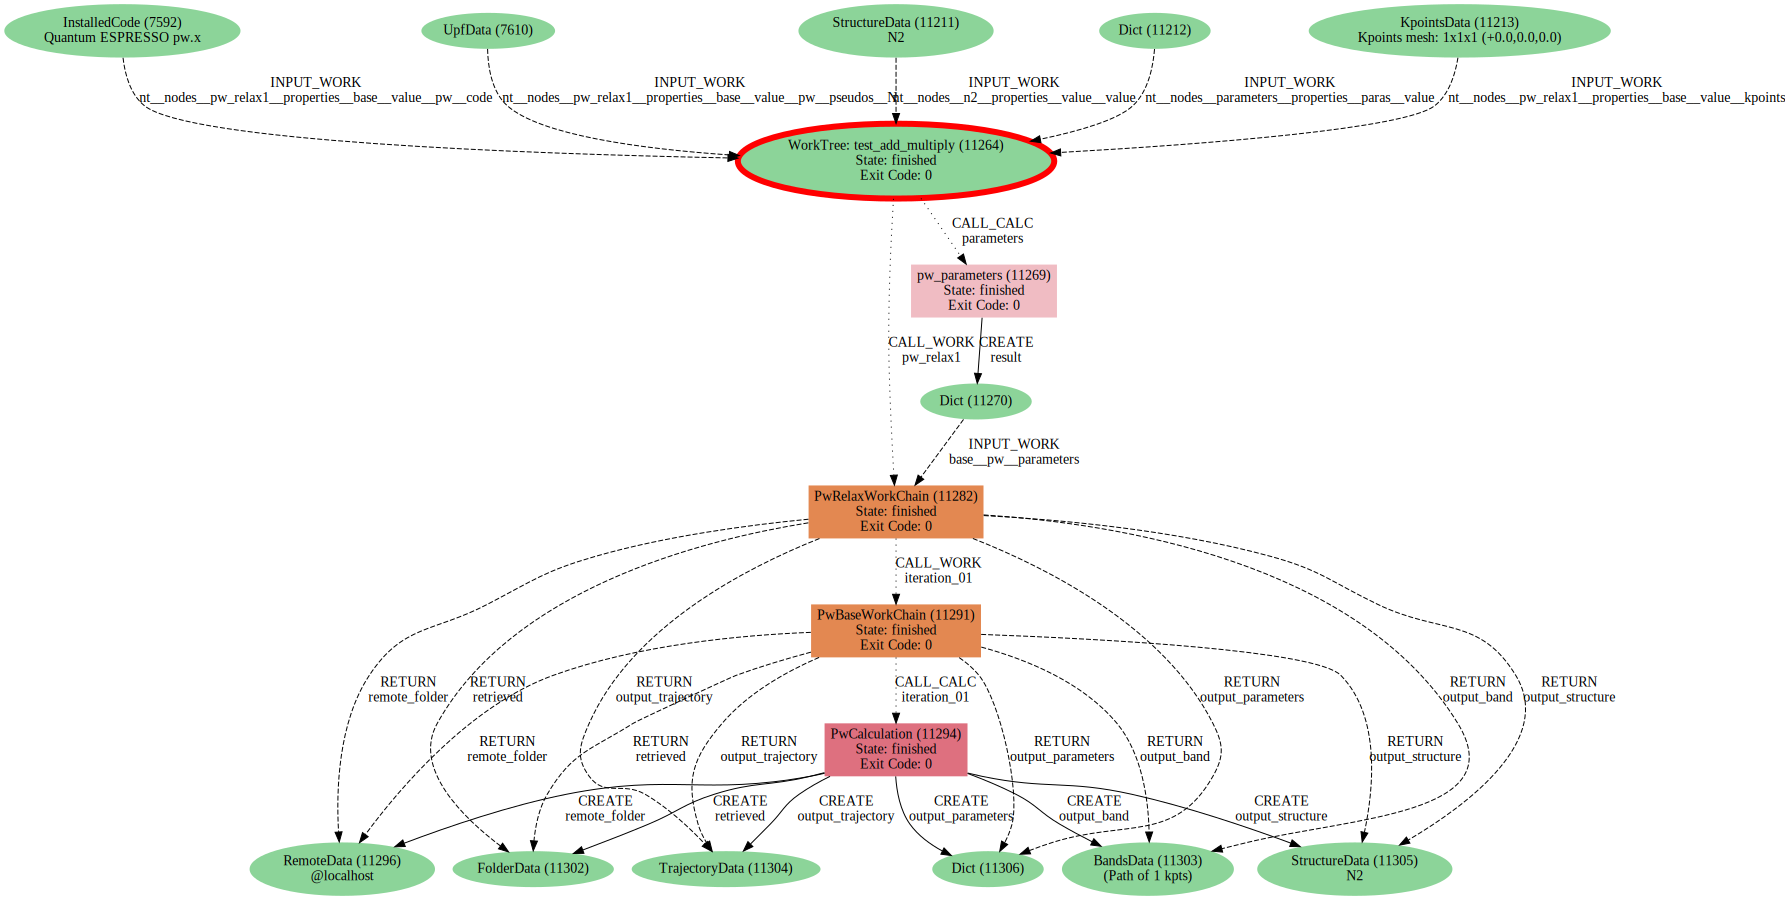

In [17]:
from aiida_worktree.utils import generate_node_graph
generate_node_graph(nt.pk)